# Breakthrough Listen: Voyager 1 Observations Using Julia

[Voyager 1](https://en.wikipedia.org/wiki/Voyager_1) is the most distant man-made object from Earth. Launched by NASA in 1977, it has travelled at fantastic speed (roughly 17,000 m/s), past the outer boundaries of our Solar System and into interstellar space (>12.5 billion miles from the Sun).

Remarkably, 45 years on, Voyager 1 is still sending telemetry data (notwithstanding recent issues)  from the depths of interstellar space. This makes it a great systems test for the Breakthrough Listen signal processing pipeline.

In this tutorial, we load, read, and plot some Breakthrough Listen (BL) observations of Voyager 1. The data were taken using the [Robert C. Byrd Greenbank Telescope](https://greenbankobservatory.org/) in West Virginia.

## About this tutorial

This tutorial introduces you to BL filterbank data. It is intended for intermediate to advanced users, who have experience with scientific/data science Python and basic astronomy. With this background, learning about Julia using this tutorial will be a cinch! First, you'll need to have [Jupyter](https://jupyter.org/) installed, along with a the latest version of [Julia](https://julialang.org/).

## About the data

We used the Greenbank X-band receiver (8.0-11.6 GHz) on December 30, 2015, to observe the known position of Voyager 1. The BL digital signal processing system saves digitized data in a 'raw' format, which we have converted into 'filterbank' format.

For the purposes of this tutorial, we suggest that you download the 504 MB file [`voyager_f1032192_t300_v2.fil`](https://storage.googleapis.com/gbt_fil/voyager_f1032192_t300_v2.fil) from the BL data archive.

### Filterbank format and the Blio package for Julia

The voyager data is stored in filterbank format, a simple binary file format that is detailed in the [SIGPROC user guide](http://sigproc.sourceforge.net/sigproc.pdf).

The following are some simple steps to add the Blio package to your install of Julia in order to handle the I/O of these Filterbank files. However, these instruction are meant for Unix operating systems. For Windows, further configuration would be required.

Firstly, open a terminal window to and start the Julia REPL interface by typing 'julia' as shown below:

`user@name:~$ julia`

If installed correctly, Julia will load and print a message similar to below:

```            
               _
   _       _ _(_)_     |  Documentation: https://docs.julialang.org
  (_)     | (_) (_)    |
   _ _   _| |_  __ _   |  Type "?" for help, "]?" for Pkg help.
  | | | | | | |/ _` |  |
  | | |_| | | | (_| |  |  Version 1.7.3 (2022-05-06)
 _/ |\__'_|_|_|\__'_|  |  Official https://julialang.org/ release
|__/                   |
```

There should now be a command line prompt for Julia (similar to the >>> in Python) that looks like:

`julia>`

From here, the Julia package manager is accessed by typing ']' which should change the command prompt to:

`(v1.7) pkg>`

The command to add the needed Blio package can then be entered to pull directly from GitHub.

`(v1.7) pkg> add https://github.com/david-macmahon/Blio.jl`

Once the package has finished installing, you should be all set to begin manipulating Filterbank data files. Also ensure that the Plots package is installed, or simply enter `add Plots` in the `pkg>` manager. 

# Lets get started!

First, lets make use of the packages we previously installed.

In [1]:
using Blio
using Plots

We can then specify the voyager .fil filepath, and open it.

In [13]:
fname = "/mnt_home/kjordan/JuliaWork/voyager_f1032192_t300_v2.fil"
fb = open(fname)

IOStream(<file /mnt_home/kjordan/JuliaWork/voyager_f1032192_t300_v2.fil>)

We can get basic info about the file by reading the filterbank header. This can be done by:

In [3]:
fbh = read(fb, Filterbank.Header)

Blio.Filterbank.Header with 22 entries:
  :rawdatafile  => "./blc3_2bit_guppi_57386_VOYAGER1_0004.0000.raw"
  :source_name  => "VOYAGER1"
  :machine_id   => 20
  :telescope_id => 6
  :src_raj      => 17.1996
  :src_dej      => 11.9493
  :az_start     => 0.0
  :za_start     => 0.0
  :data_type    => 1
  :fch1         => 8588.96
  :foff         => -2.83832e-6
  :nchans       => 66060288
  :nbeams       => 1
  :ibeam        => 1
  :nbits        => 32
  :tstart       => 57386.9
  :tsamp        => 105.696
  :nifs         => 1
  :header_size  => 388
  ⋮             => ⋮

The specifics are discussed in detail in the [SIGPROC user guide](http://sigproc.sourceforge.net/sigproc.pdf). Briefly, astronomers use a Celestial coordinate system to specify the location of objects in outer space. The `src_raj` and `src_dej` specify the [J2000](https://en.wikipedia.org/wiki/Epoch_%28astronomy%29#Julian_years_and_J2000) coordinates, in terms of Right Ascension and Declination (RA & DEC), toward which the telescope is pointing. `tstart` specifies the [Julian Date](https://en.wikipedia.org/wiki/Julian_day) of the observation, and `fch1` and `foff` specify the frequency of the first and frequency increment of each data channel respectively, in MHz.

We can also look directly at header and data 

In [4]:
print(fbh)
size(fbh)

Blio.Filterbank.Header(

:rawdatafile => "./blc3_2bit_guppi_57386_VOYAGER1_0004.0000.raw", :source_name => "VOYAGER1", :machine_id => 20, :telescope_id => 6, 

:src_raj => 17.199646666666666, :src_dej => 11.9493, :az_start => 0.0, :za_start => 0.0, :data_type => 1, :fch1 => 8588.964842330843, :foff => -2.838316417875744e-6, :nchans => 66060288, :nbeams => 1, :ibeam => 1, :nbits => 32, :tstart => 57386.864907407406, :tsamp => 105.6964608, :nifs => 1, :header_size => 388, :data_size => 528482304, :sample_size => 264241152, :nsamps => 2)

(66060288, 1, 2)

The data has the shape (66060288, 1, 2), meaning that is has 2 time integrations, and 66,060,288 channels, over a bandwidth of 187 MHz. For the record, that's a lot of channels! The corresponding channel bandwidth is far more than that required for most astrophysical observations.

## Plotting the data

Before we can begin plotting, the data needs to be read into an array:

In [5]:
data = Array(fbh, 1, dropdims=true)
read!(fb, data)

66060288-element Vector{Float32}:
 3.1735828f9
 2.9683325f9
 2.9714248f9
 3.0330555f9
 3.0348472f9
 3.121117f9
 3.153143f9
 3.199613f9
 3.1566794f9
 3.0353997f9
 ⋮
 3.0847956f9
 3.220472f9
 3.175843f9
 2.9148357f9
 3.065591f9
 2.9835825f9
 3.1866796f9
 3.1087017f9
 3.089743f9

Now that the data has been loaded into the array, we need to extract the range of frequencies that the file contains. Then, in order to reduce rendering time for the initial plot of the whole spectrum, every 500th channel measurment is seleted to be plotted. The `plot()` funtion is then called with parameters added for maximum data clarity:

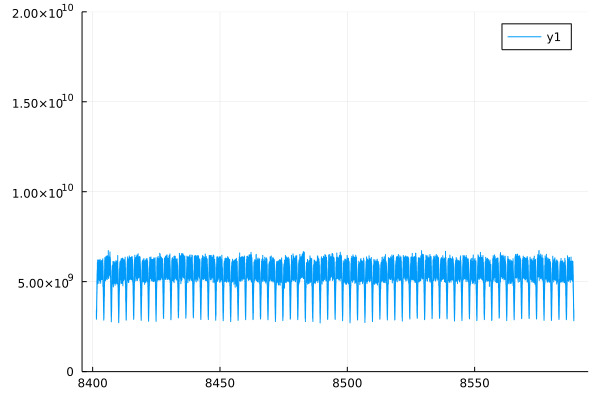

In [6]:
freqs = chanfreqs(fbh)
r = 1:500:66060288
plot(freqs[r], data[r,1], ylims = (0, 2*10^10))

What we see here is the power spectral density (or simply "spectrum") of the data contained in the filterbank file. Apparent in the plot are discontinuities due to the BL digital filters, but not a lot else. Voyager is a very narrowband signal, so we can't easily see it in this plot. However, if we zoom in on where Voyager's telemetry is known to be, we see some very narrowband signals:

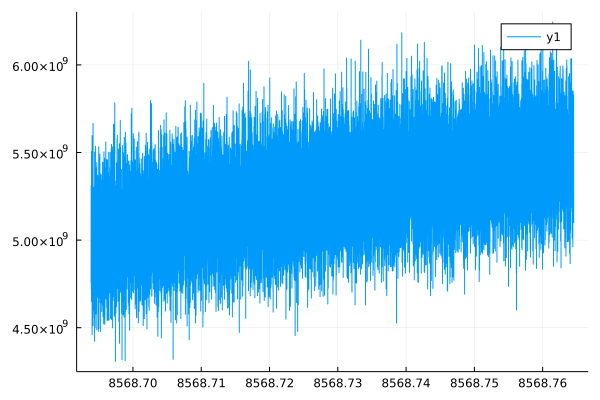

In [7]:
f = 7117000:7141900
plot(freqs[f], data[f,1])